# XGBoost
In this notebook we present a XGBoost baseline. We train GroupKFold models for each of the 18 questions. Our CV score is 0.678. We infer test using one of our KFold models. We can improve our CV and LB by engineering more features for our xgboost and/or trying different models (like other ML models and/or RNN and/or Transformer). Also we can improve our LB by using more KFold models OR training one model using all data (and the hyperparameters that we found from our KFold cross validation).


[1]: https://www.kaggle.com/competitions/predict-student-performance-from-game-play/discussion/386218

In [1]:
import pandas as pd, numpy as np, gc
from sklearn.model_selection import KFold, GroupKFold
from xgboost import XGBClassifier
from sklearn.metrics import f1_score

# Load Train Data and Labels
On March 20 2023, Kaggle doubled the size of train data (discussion [here][1]). The train data is now 4.7GB! To avoid memory error, we will read the train data in as 10 pieces and feature engineer each piece before reading the next piece. This works because feature engineering shrinks the size of each piece.

[1]: https://www.kaggle.com/competitions/predict-student-performance-from-game-play/discussion/396202

In [2]:
# READ USER ID ONLY
tmp = pd.read_csv("/kaggle/input/predict-student-performance-from-game-play/train.csv",usecols=[0])
tmp = tmp.groupby('session_id').session_id.agg('count')

# COMPUTE READS AND SKIPS
PIECES = 10
CHUNK = int( np.ceil(len(tmp)/PIECES) )

reads = []
skips = [0]
for k in range(PIECES):
    a = k*CHUNK
    b = (k+1)*CHUNK
    if b>len(tmp): b=len(tmp)
    r = tmp.iloc[a:b].sum()
    reads.append(r)
    skips.append(skips[-1]+r)
    
print(f'To avoid memory error, we will read train in {PIECES} pieces of sizes:')
print(reads)

To avoid memory error, we will read train in 10 pieces of sizes:
[2684191, 2631991, 2638304, 2657670, 2644229, 2629801, 2596616, 2602258, 2619995, 2591891]


In [3]:
train = pd.read_csv('/kaggle/input/predict-student-performance-from-game-play/train.csv', nrows=reads[0])
print('Train size of first piece:', train.shape )
train.head()

Train size of first piece: (2684191, 20)


,session_id,index,elapsed_time,event_name,name,level,page,room_coor_x,room_coor_y,screen_coor_x,screen_coor_y,hover_duration,text,fqid,room_fqid,text_fqid,fullscreen,hq,music,level_group
0,20090312431273200,0,0,cutscene_click,basic,0,NaN,-413.991405,-159.314686,380.0,494.0,NaN,undefined,intro,tunic.historicalsociety.closet,tunic.historicalsociety.closet.intro,0,0,1,0-4
1,20090312431273200,1,1323,person_click,basic,0,NaN,-413.991405,-159.314686,380.0,494.0,NaN,"Whatcha doing over there, Jo?",gramps,tunic.historicalsociety.closet,tunic.historicalsociety.closet.gramps.intro_0_...,0,0,1,0-4
2,20090312431273200,2,831,person_click,basic,0,NaN,-413.991405,-159.314686,380.0,494.0,NaN,Just talking to Teddy.,gramps,tunic.historicalsociety.closet,tunic.historicalsociety.closet.gramps.intro_0_...,0,0,1,0-4
3,20090312431273200,3,1147,person_click,basic,0,NaN,-413.991405,-159.314686,380.0,494.0,NaN,I gotta run to my meeting!,gramps,tunic.historicalsociety.closet,tunic.historicalsociety.closet.gramps.intro_0_...,0,0,1,0-4
4,20090312431273200,4,1863,person_click,basic,0,NaN,-412.991405,-159.314686,381.0,494.0,NaN,"Can I come, Gramps?",gramps,tunic.historicalsociety.closet,tunic.historicalsociety.closet.gramps.intro_0_...,0,0,1,0-4


In [4]:
targets = pd.read_csv('/kaggle/input/predict-student-performance-from-game-play/train_labels.csv')
targets['session'] = targets.session_id.apply(lambda x: int(x.split('_')[0]) )
targets['q'] = targets.session_id.apply(lambda x: int(x.split('_')[-1][1:]) )
print( targets.shape )
targets.head()

(424116, 4)


,session_id,correct,session,q
0,20090312431273200_q1,1,20090312431273200,1
1,20090312433251036_q1,0,20090312433251036,1
2,20090312455206810_q1,1,20090312455206810,1
3,20090313091715820_q1,0,20090313091715820,1
4,20090313571836404_q1,1,20090313571836404,1


# Feature Engineer
We create basic aggregate features. Try creating more features to boost CV and LB! The idea for EVENTS feature is from [here][1]

[1]: https://www.kaggle.com/code/kimtaehun/lightgbm-baseline-with-aggregated-log-data

In [5]:
CATS = ['event_name', 'fqid', 'room_fqid', 'text']
NUMS = ['elapsed_time','level','page','room_coor_x', 'room_coor_y', 
        'screen_coor_x', 'screen_coor_y', 'hover_duration']

# https://www.kaggle.com/code/kimtaehun/lightgbm-baseline-with-aggregated-log-data
EVENTS = ['navigate_click','person_click','cutscene_click','object_click',
          'map_hover','notification_click','map_click','observation_click',
          'checkpoint']

In [6]:
def feature_engineer(train):
    
    dfs = []
    for c in CATS:
        tmp = train.groupby(['session_id','level_group'])[c].agg('nunique')
        tmp.name = tmp.name + '_nunique'
        dfs.append(tmp)
    for c in NUMS:
        tmp = train.groupby(['session_id','level_group'])[c].agg('mean')
        tmp.name = tmp.name + '_mean'
        dfs.append(tmp)
    for c in NUMS:
        tmp = train.groupby(['session_id','level_group'])[c].agg('std')
        tmp.name = tmp.name + '_std'
        dfs.append(tmp)
    for c in NUMS:
        tmp = train.groupby(['session_id','level_group'])[c].agg('median')
        tmp.name = tmp.name + '_median'
        dfs.append(tmp)
    for c in EVENTS: 
        train[c] = (train.event_name == c).astype('int8')
    for c in EVENTS + ['elapsed_time']:
        tmp = train.groupby(['session_id','level_group'])[c].agg('sum')
        tmp.name = tmp.name + '_sum'
        dfs.append(tmp)
    train = train.drop(EVENTS,axis=1)
        
    df = pd.concat(dfs,axis=1)
    df = df.fillna(-1)
    df = df.reset_index()
    df = df.set_index('session_id')
    return df

In [7]:
%%time

# PROCESS TRAIN DATA IN PIECES
all_pieces = []
print(f'Processing train as {PIECES} pieces to avoid memory error... ')
for k in range(PIECES):
    print(k,', ',end='')
    SKIPS = 0
    if k>0: SKIPS = range(1,skips[k]+1)
    train = pd.read_csv('/kaggle/input/predict-student-performance-from-game-play/train.csv',
                        nrows=reads[k], skiprows=SKIPS)
    df = feature_engineer(train)
    all_pieces.append(df)
    
# CONCATENATE ALL PIECES
print('\n')
del train; gc.collect()
df = pd.concat(all_pieces, axis=0)
print('Shape of all train data after feature engineering:', df.shape )
df.head()

Processing train as 10 pieces to avoid memory error... 
0 , 1 , 2 , 3 , 4 , 5 , 6 , 7 , 8 , 9 , 

Shape of all train data after feature engineering: (70686, 39)
CPU times: user 8min 22s, sys: 22.4 s, total: 8min 45s
Wall time: 9min 23s


,level_group,event_name_nunique,fqid_nunique,room_fqid_nunique,text_nunique,elapsed_time_mean,level_mean,page_mean,room_coor_x_mean,room_coor_y_mean,...,navigate_click_sum,person_click_sum,cutscene_click_sum,object_click_sum,map_hover_sum,notification_click_sum,map_click_sum,observation_click_sum,checkpoint_sum,elapsed_time_sum
session_id,,,,,,,,,,,,,,,,,,,,,
20090312431273200,0-4,10,30,7,56,8.579356e+04,1.945455,-1.0,7.701275,-71.413749,...,81.0,22.0,28.0,11.0,4.0,8,2.0,4,1,14155937
20090312431273200,13-22,10,49,12,168,1.040601e+06,17.402381,-1.0,-130.347170,-162.004310,...,170.0,123.0,60.0,20.0,14.0,10,6.0,3,1,437052322
20090312431273200,5-12,10,39,11,124,3.572052e+05,8.054054,-1.0,14.306062,-57.269322,...,103.0,104.0,12.0,28.0,9.0,9,8.0,1,1,105732736
20090312433251036,0-4,11,22,6,49,9.763342e+04,1.870504,0.0,-84.045960,-53.671082,...,49.0,18.0,36.0,15.0,3.0,5,3.0,2,1,13571045
20090312433251036,13-22,11,73,16,183,2.498852e+06,17.762529,5.1,-30.762282,-142.861892,...,637.0,145.0,65.0,83.0,186.0,14,45.0,5,1,3241011333


# Train XGBoost Model
We train one model for each of 18 questions. Furthermore, we use data from `level_groups = '0-4'` to train model for questions 1-3, and `level groups '5-12'` to train questions 4 thru 13 and `level groups '13-22'` to train questions 14 thru 18. Because this is the data we get (to predict corresponding questions) from Kaggle's inference API during test inference. We can improve our model by saving a user's previous data from earlier `level_groups` and using that to predict future `level_groups`.

In [8]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
from datetime import datetime
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import StratifiedKFold
from xgboost import XGBClassifier

In [9]:
FEATURES = [c for c in df.columns if c != 'level_group']
print('We will train with', len(FEATURES) ,'features')
ALL_USERS = df.index.unique()
print('We will train with', len(ALL_USERS) ,'users info')

We will train with 38 features
We will train with 23562 users info


In [10]:
gkf = GroupKFold(n_splits=5)
oof = pd.DataFrame(data=np.zeros((len(ALL_USERS),18)), index=ALL_USERS)
models = {}

In [11]:

# COMPUTE CV SCORE WITH 5 GROUP K FOLD
for i, (train_index, test_index) in enumerate(gkf.split(X=df, groups=df.index)):
    print('#'*25)
    print('### Fold',i+1)
    print('#'*25)
    
    xgb_params = {
    'objective' : 'binary:logistic',
    'eval_metric':'aucpr',
    'max_depth': 3, 'gamma': 5, 'colsample_bytree': 1.0,
    'learning_rate': 0.05,
    'max_depth': 4,
    'n_estimators': 1000,
    'early_stopping_rounds': 50,
    'tree_method':'hist',
    'subsample':0.8,
    'colsample_bytree': 0.4,
    'use_label_encoder' : False}
    
    # ITERATE THRU QUESTIONS 1 THRU 18
    for t in range(1,19):
        
        # USE THIS TRAIN DATA WITH THESE QUESTIONS
        if t<=3: grp = '0-4'
        elif t<=13: grp = '5-12'
        elif t<=22: grp = '13-22'
            
        # TRAIN DATA
        train_x = df.iloc[train_index]
        train_x = train_x.loc[train_x.level_group == grp]
        train_users = train_x.index.values
        train_y = targets.loc[targets.q==t].set_index('session').loc[train_users]
        
        # VALID DATA
        valid_x = df.iloc[test_index]
        valid_x = valid_x.loc[valid_x.level_group == grp]
        valid_users = valid_x.index.values
        valid_y = targets.loc[targets.q==t].set_index('session').loc[valid_users]
        
        # TRAIN MODEL        
        clf =  XGBClassifier(**xgb_params)
        clf.fit(train_x[FEATURES].astype('float32'), train_y['correct'],
                eval_set=[ (valid_x[FEATURES].astype('float32'), valid_y['correct']) ],
                verbose=0)
        print(f'{t}({clf.best_ntree_limit}), ',end='')
        
        # SAVE MODEL, PREDICT VALID OOF
        models[f'{grp}_{t}'] = clf
        oof.loc[valid_users, t-1] = clf.predict_proba(valid_x[FEATURES].astype('float32'))[:,1]
        
    print()

#########################
### Fold 1
#########################
1(67), 2(87), 3(77), 4(72), 5(141), 6(59), 7(96), 8(35), 9(105), 10(200), 11(82), 12(57), 13(37), 14(309), 15(57), 16(37), 17(66), 18(135), 
#########################
### Fold 2
#########################
1(137), 2(62), 3(44), 4(83), 5(141), 6(129), 7(112), 8(6), 9(97), 10(97), 11(140), 12(95), 13(93), 14(287), 15(177), 16(58), 17(126), 18(162), 
#########################
### Fold 3
#########################
1(150), 2(108), 3(99), 4(246), 5(232), 6(133), 7(92), 8(42), 9(96), 10(114), 11(131), 12(16), 13(160), 14(195), 15(195), 16(89), 17(74), 18(131), 
#########################
### Fold 4
#########################
1(107), 2(122), 3(87), 4(174), 5(218), 6(205), 7(96), 8(47), 9(107), 10(155), 11(26), 12(100), 13(260), 14(256), 15(351), 16(31), 17(137), 18(244), 
#########################
### Fold 5
#########################
1(153), 2(98), 3(59), 4(172), 5(171), 6(176), 7(159), 8(62), 9(137), 10(358), 11(65), 12(40), 13(191), 1

# Compute CV Score
We need to convert prediction probabilities into `1s` and `0s`. The competition metric is F1 Score which is the harmonic mean of precision and recall. Let's find the optimal threshold for `p > threshold` when to predict `1` and when to predict `0` to maximize F1 Score.

In [12]:
# PUT TRUE LABELS INTO DATAFRAME WITH 18 COLUMNS
true = oof.copy()
for k in range(18):
    # GET TRUE LABELS
    tmp = targets.loc[targets.q == k+1].set_index('session').loc[ALL_USERS]
    true[k] = tmp.correct.values

In [13]:
# FIND BEST THRESHOLD TO CONVERT PROBS INTO 1s AND 0s
scores = []; thresholds = []
best_score = 0; best_threshold = 0

for threshold in np.arange(0.4,0.81,0.01):
    print(f'{threshold:.02f}, ',end='')
    preds = (oof.values.reshape((-1))>threshold).astype('int')
    m = f1_score(true.values.reshape((-1)), preds, average='macro')   
    scores.append(m)
    thresholds.append(threshold)
    if m>best_score:
        best_score = m
        best_threshold = threshold

0.40, 0.41, 0.42, 0.43, 0.44, 0.45, 0.46, 0.47, 0.48, 0.49, 0.50, 0.51, 0.52, 0.53, 0.54, 0.55, 0.56, 0.57, 0.58, 0.59, 0.60, 0.61, 0.62, 0.63, 0.64, 0.65, 0.66, 0.67, 0.68, 0.69, 0.70, 0.71, 0.72, 0.73, 0.74, 0.75, 0.76, 0.77, 0.78, 0.79, 0.80, 

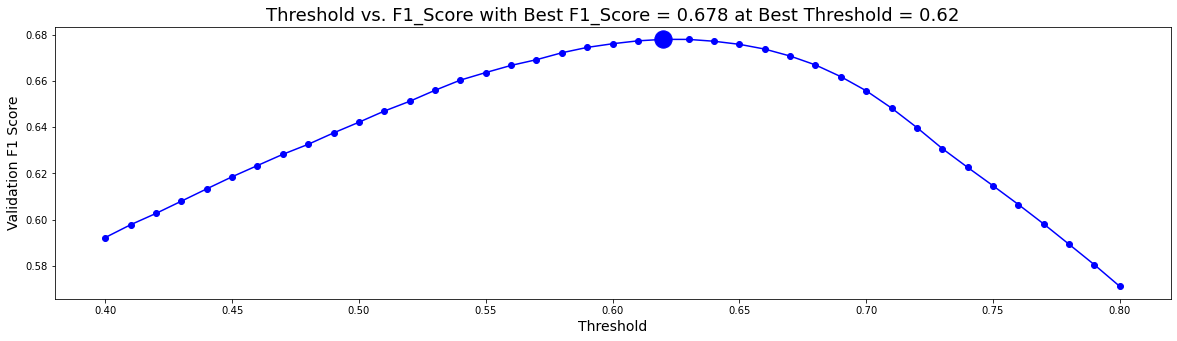

In [14]:
import matplotlib.pyplot as plt

# PLOT THRESHOLD VS. F1_SCORE
plt.figure(figsize=(20,5))
plt.plot(thresholds,scores,'-o',color='blue')
plt.scatter([best_threshold], [best_score], color='blue', s=300, alpha=1)
plt.xlabel('Threshold',size=14)
plt.ylabel('Validation F1 Score',size=14)
plt.title(f'Threshold vs. F1_Score with Best F1_Score = {best_score:.3f} at Best Threshold = {best_threshold:.3}',size=18)
plt.show()

In [15]:
print('When using optimal threshold...')
for k in range(18):
        
    # COMPUTE F1 SCORE PER QUESTION
    m = f1_score(true[k].values, (oof[k].values>best_threshold).astype('int'), average='macro')
    print(f'Q{k}: F1 =',m)
    
# COMPUTE F1 SCORE OVERALL
m = f1_score(true.values.reshape((-1)), (oof.values.reshape((-1))>best_threshold).astype('int'), average='macro')
print('==> Overall F1 =',m)

When using optimal threshold...
Q0: F1 = 0.5957513776502266
Q1: F1 = 0.49464879356568364
Q2: F1 = 0.48548116196511043
Q3: F1 = 0.6060871712845352
Q4: F1 = 0.5863660091252918
Q5: F1 = 0.6045186910578344
Q6: F1 = 0.579384426639705
Q7: F1 = 0.5011034136857511
Q8: F1 = 0.5961498758808184
Q9: F1 = 0.5324998428450508
Q10: F1 = 0.5919126750565239
Q11: F1 = 0.49227461199120687
Q12: F1 = 0.4346616000005588
Q13: F1 = 0.6062454785572561
Q14: F1 = 0.5174690079394743
Q15: F1 = 0.4599226455607506
Q16: F1 = 0.5248617293744199
Q17: F1 = 0.49078980543971357
==> Overall F1 = 0.6779630797426471


# Infer Test Data

In [16]:
# IMPORT KAGGLE API
import jo_wilder
env = jo_wilder.make_env()
iter_test = env.iter_test()

# CLEAR MEMORY
import gc
del targets, df, oof, true
_ = gc.collect()

In [17]:
limits = {'0-4':(1,4), '5-12':(4,14), '13-22':(14,19)}

for (test, sample_submission) in iter_test:
    
    # FEATURE ENGINEER TEST DATA
    df = feature_engineer(test)
    
    # INFER TEST DATA
    grp = test.level_group.values[0]
    a,b = limits[grp]
    for t in range(a,b):
        clf = models[f'{grp}_{t}']
        p = clf.predict_proba(df[FEATURES].astype('float32'))[0,1]
        mask = sample_submission.session_id.str.contains(f'q{t}')
        sample_submission.loc[mask,'correct'] = int( p > best_threshold )
    
    env.predict(sample_submission)

This version of the API is not optimized and should not be used to estimate the runtime of your code on the hidden test set.


# EDA submission.csv

In [18]:
df = pd.read_csv('submission.csv')
print( df.shape )
df.head()

(54, 2)


,session_id,correct
0,20090109393214576_q1,1
1,20090109393214576_q2,1
2,20090109393214576_q3,1
3,20090109393214576_q4,1
4,20090109393214576_q5,0


In [19]:
print(df.correct.mean())

0.5925925925925926
